# setup

In [5]:
import datetime
import gc
import json
import os
import sys
import pprint
import warnings
from io import BytesIO
import psutil

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import netCDF4 as nc
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from IPython.display import display
from scipy.interpolate import griddata
from skimage.transform import resize
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.preprocessing import MinMaxScaler

mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings("ignore")

%matplotlib inline

In [6]:
print(os.uname())
print("Cores: ", os.cpu_count())
print("Memory: ", round(psutil.virtual_memory().total / 1024 / 1024 / 1024, 2), "GB")
print()
print(sys.version)
print(sys.version_info)

posix.uname_result(sysname='Linux', nodename='u22', release='6.2.0-36-generic', version='#37~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Oct  9 15:34:04 UTC 2', machine='x86_64')
Cores:  16
Memory:  15.54 GB

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)


In [7]:
def sizeof_fmt(num, suffix='B'):
    """
    Convert size of objects in memory
    """
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "{:>6.1f} {}{}".format(num, unit, suffix)
        num /= 1024.0
    return "{:.1f} {}{}".format(num, 'Yi', suffix)

In [8]:
sns.set_style("whitegrid")

plt.rcParams.update({
    'font.size'       : 9,
    'figure.figsize'  : (3.5, 2.8),
    'figure.dpi'      : 300,
    'savefig.dpi'     : 300,
    'text.usetex'     : True,
    'font.family'     : 'serif',
    'font.serif'      : ['Times New Roman'],
    'axes.labelsize'  : 9,
    'axes.titlesize'  : 9,
    'xtick.labelsize' : 8,
    'ytick.labelsize' : 8,
    'legend.fontsize' : 8,
    'lines.linewidth' : 1,
    'axes.linewidth'  : 1,
    'grid.linestyle'  : '--',
    'grid.linewidth'  : 0.5,
    'grid.alpha'      : 0.8,
})

sns.set_context(
    "paper", 
    rc={
        "font.size"      : 9,
        "axes.titlesize" : 9,
        "axes.labelsize" : 9, 
        'xtick.labelsize': 8,
        'ytick.labelsize': 8
    }
)

# data

In [11]:
df = pd.DataFrame()

for file in os.listdir("../data/02_intermediate/ocean_data/"):
    print(file)
    df = pd.concat([df, pd.read_parquet("../data/02_intermediate/ocean_data/" + file)])

1925.parquet
1800.parquet
1950.parquet
1960.parquet
1970.parquet
1900.parquet
1700.parquet


In [12]:
df

,z,z_level_qc,z_unc,t,t_level_qc,t_unc,s,s_level_qc,s_unc,oxygen,...,longitude,month,n_levels,probe_type,time,uid,year,originator_station,originator_cruise,originator_flag_type
0,0.0,0,NaN,17.2,0.0,NaN,36.22,0.0,NaN,NaN,...,-15.58,1,5,7.0,11.0,26678,1925,None,None,NaN
1,50.0,0,NaN,17.2,0.0,NaN,36.20,0.0,NaN,NaN,...,-15.58,1,5,7.0,11.0,26678,1925,None,None,NaN
2,100.0,0,NaN,NaN,NaN,NaN,36.20,0.0,NaN,NaN,...,-15.58,1,5,7.0,11.0,26678,1925,None,None,NaN
3,200.0,0,NaN,14.9,0.0,NaN,35.77,0.0,NaN,NaN,...,-15.58,1,5,7.0,11.0,26678,1925,None,None,NaN
4,300.0,0,NaN,12.5,0.0,NaN,35.68,0.0,NaN,NaN,...,-15.58,1,5,7.0,11.0,26678,1925,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19418,50.0,0,NaN,17.2,0.0,NaN,36.20,0.0,NaN,NaN,...,-15.58,1,5,7.0,11.0,26678,1925,None,None,NaN
19419,100.0,0,NaN,NaN,NaN,NaN,36.20,0.0,NaN,NaN,...,-15.58,1,5,7.0,11.0,26678,1925,None,None,NaN
19420,200.0,0,NaN,14.9,0.0,NaN,35.77,0.0,NaN,NaN,...,-15.58,1,5,7.0,11.0,26678,1925,None,None,NaN
19421,300.0,0,NaN,12.5,0.0,NaN,35.68,0.0,NaN,NaN,...,-15.58,1,5,7.0,11.0,26678,1925,None,None,NaN


# general stats

In [16]:
print("Total of unique points: ", df.drop_duplicates(subset=["uid", "z"]).shape[0])

Total of unique points:  1719589


In [18]:
print("Total of cruises: ", df.drop_duplicates(subset=["uid"]).shape[0])

Total of cruises:  170506


,z
count,170506.000000
mean,10.085369
std,8.731215
min,1.000000
25%,4.000000
50%,8.000000
75%,14.000000
max,142.000000


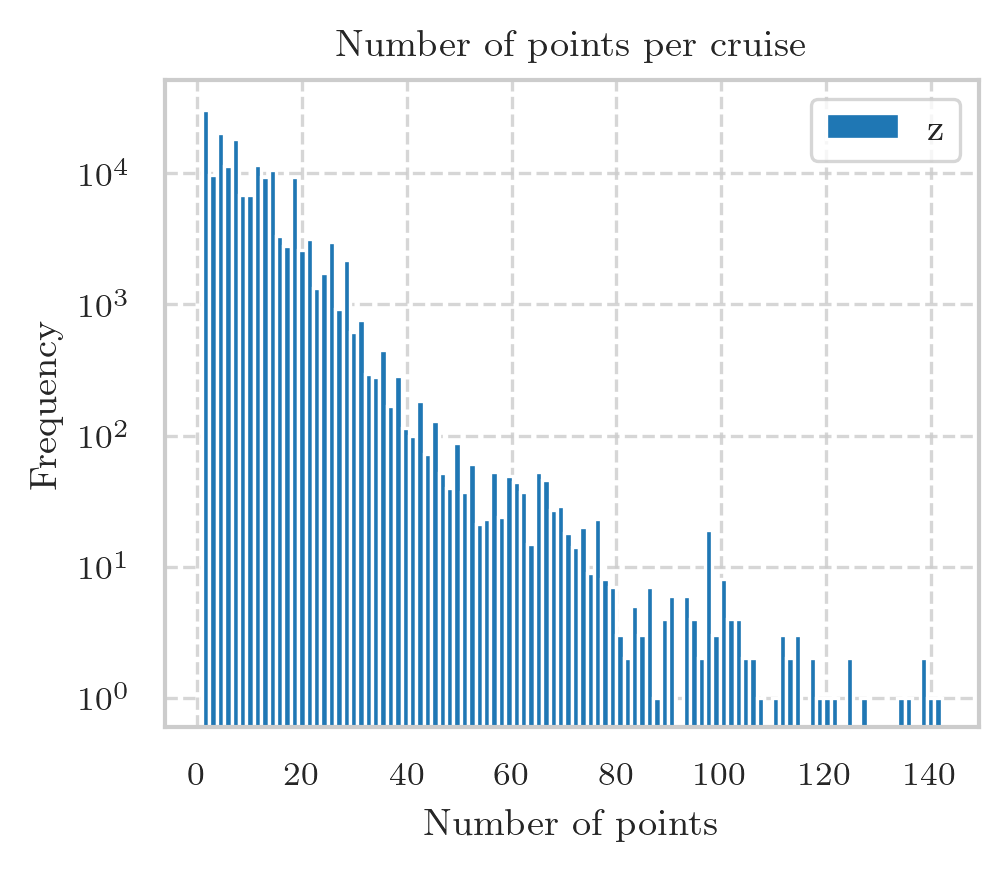

In [44]:
display( df.groupby(["uid"]).agg({"z": "count"}).describe() )

fig, ax = plt.subplots()

df.groupby(["uid"]).agg({"z": "count"}).plot.hist(bins=100, ax=ax)

ax.set_xlabel("Number of points")
ax.set_ylabel("Frequency")
ax.legend()

plt.yscale("log")

ax.set_title("Number of points per cruise")

fig.savefig("../data/08_reporting/number_of_points_per_cruise.png", bbox_inches="tight", dpi=300)

,z
count,92.000000
mean,18691.478261
std,35832.703843
min,4.000000
25%,167.250000
50%,2154.500000
75%,18133.500000
max,156759.000000


,uid
count,92.000000
mean,18691.478261
std,35832.703843
min,4.000000
25%,167.250000
50%,2154.500000
75%,18133.500000
max,156759.000000


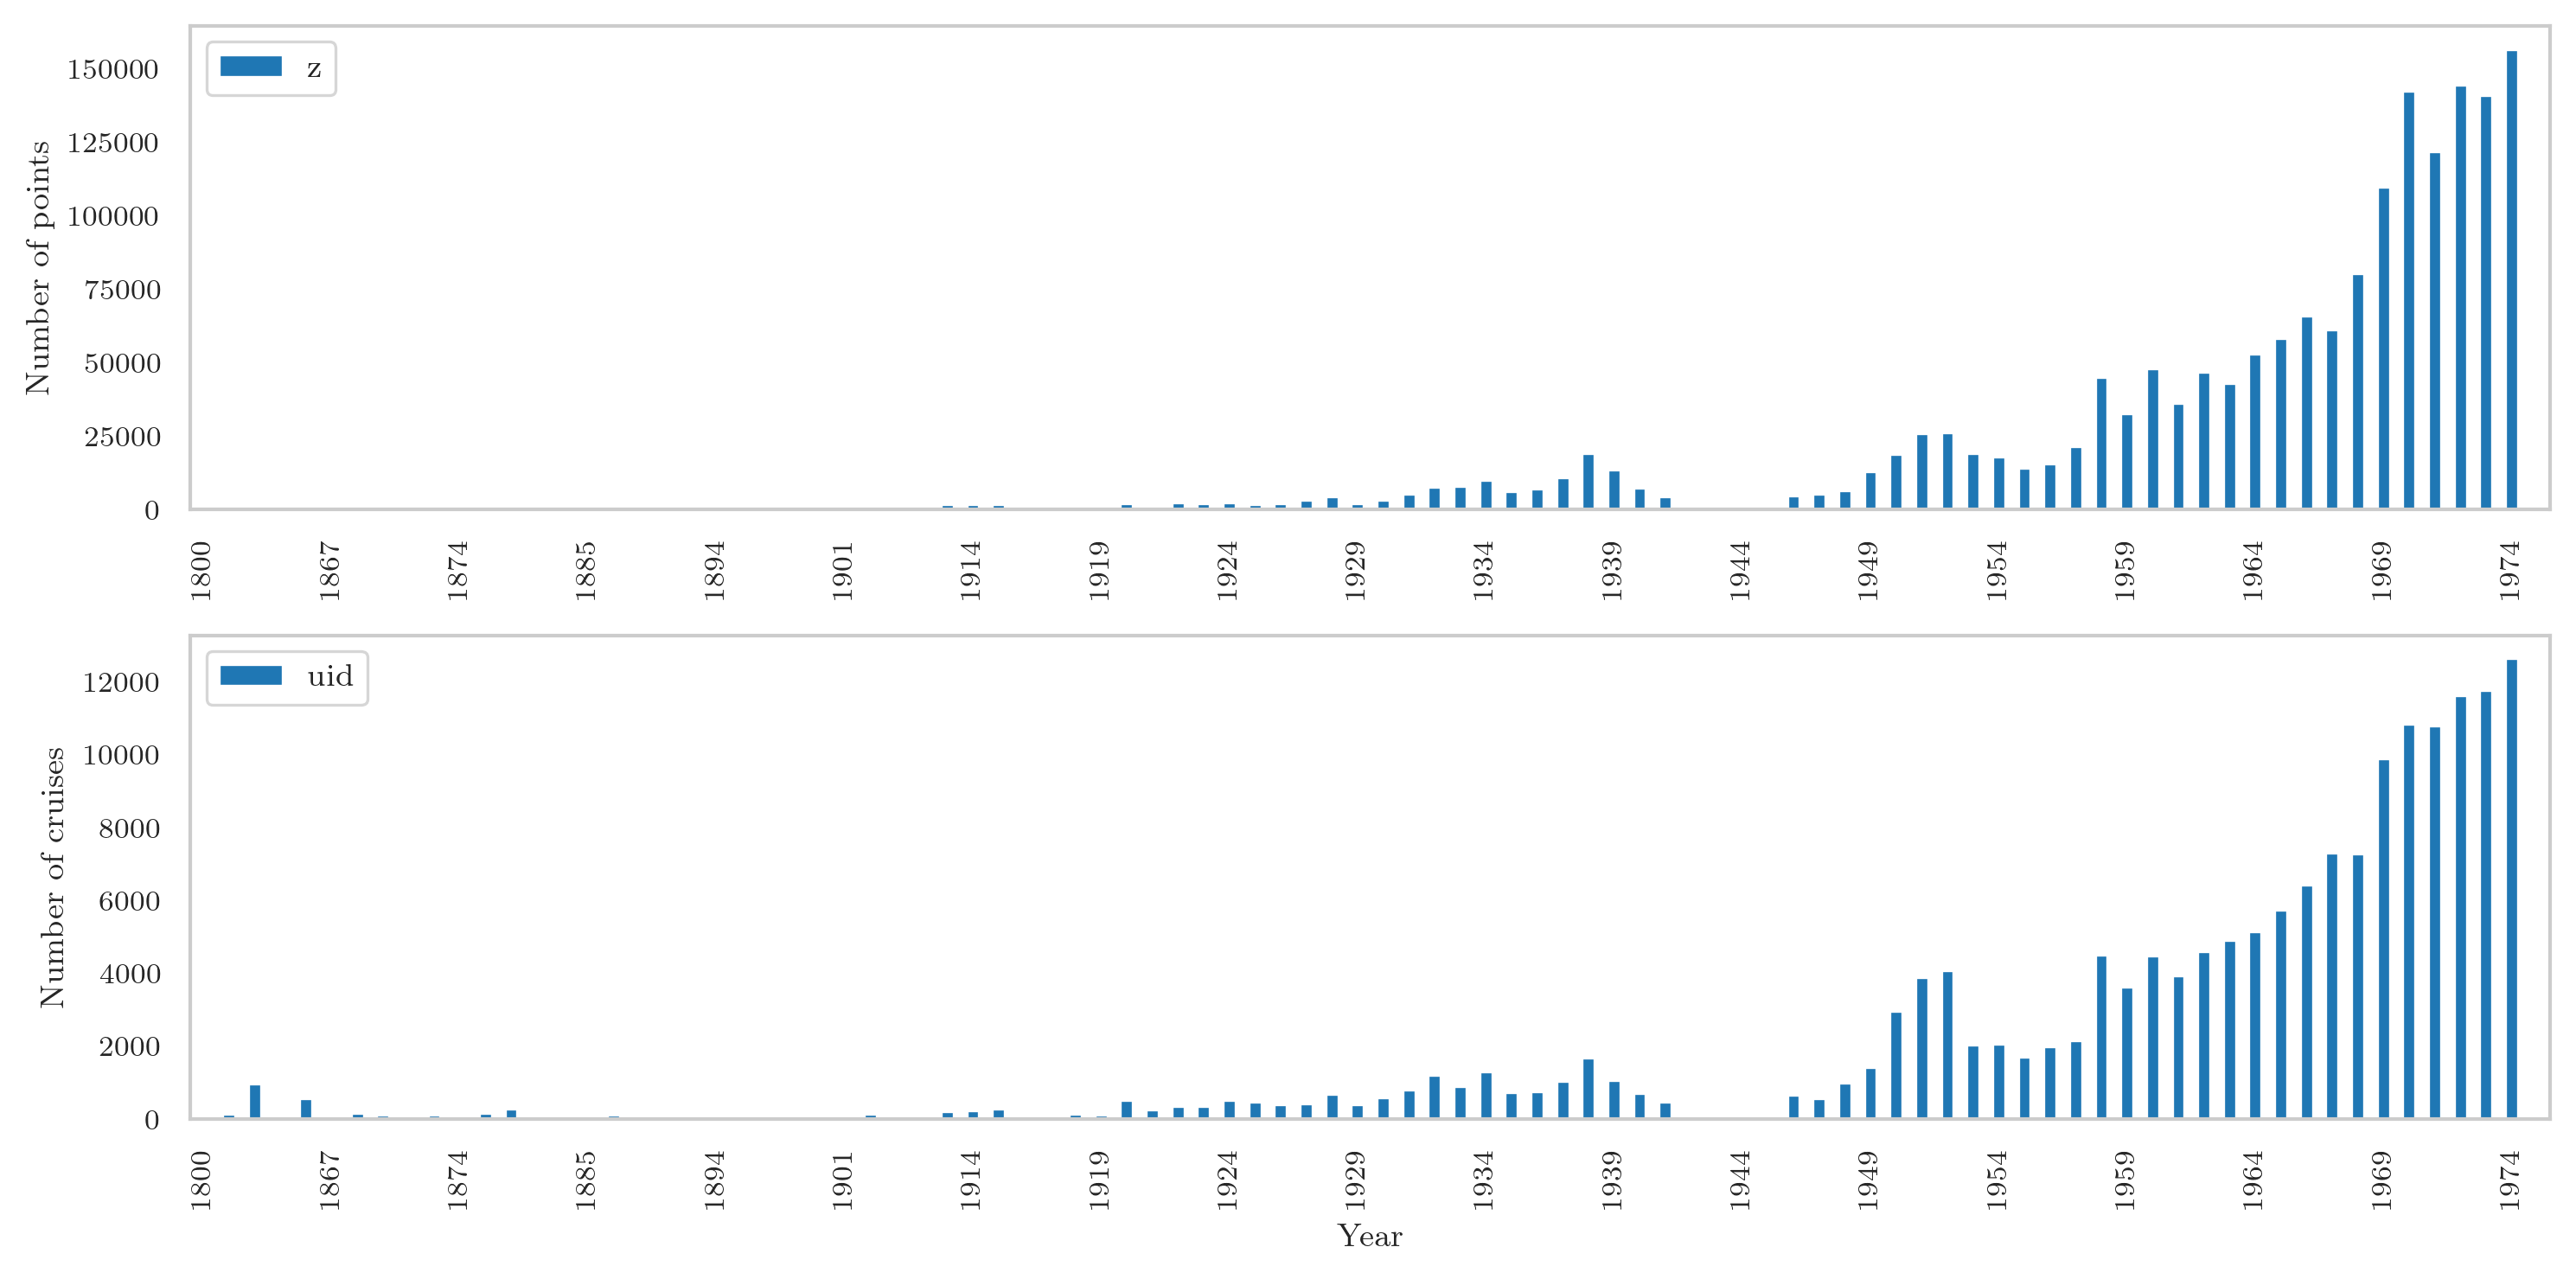

In [53]:
fig, axs = plt.subplots(figsize=(10, 5), nrows=2, ncols=1)

# measurements per year
display( df.groupby(["year"]).agg({"z": "count"}).describe() )

df.groupby(["year"]).agg({"z": "count"}).plot.bar(ax=axs[0])
axs[0].set_xlabel("")
axs[0].set_ylabel("Number of points")
axs[0].legend()
# axs[0].set_title("Number of points per year")
axs[0].grid(False)
axs[0].xaxis.set_major_locator(plt.MaxNLocator(20))

# cruises per year
display( df.groupby(["year"]).agg({"uid": "count"}).describe() )

df.groupby(["year"]).agg({"uid": "nunique"}).plot.bar(ax=axs[1])
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Number of cruises")
axs[1].legend()
# axs[1].set_title("Number of points per year")
axs[1].grid(False)
axs[1].xaxis.set_major_locator(plt.MaxNLocator(20))

plt.tight_layout()

fig.savefig("../data/08_reporting/number_of_points_per_year.png", bbox_inches="tight", dpi=300)

In [ ]:
fig, axs = plt.subplots(figsize=(10, 5), nrows=2, ncols=1)

# max depth measurement over years


## single measurement

In [61]:
agg_ = df.groupby(["uid"]).agg({"z": "count"}).reset_index()
sample_uid = agg_.loc[agg_["z"] > 100].sample(1, random_state=1)["uid"].values[0]
subdf = df.loc[df["uid"]==sample_uid,:].copy()

subdf 

,z,z_level_qc,z_unc,t,t_level_qc,t_unc,s,s_level_qc,s_unc,oxygen,...,longitude,month,n_levels,probe_type,time,uid,year,originator_station,originator_cruise,originator_flag_type
543823,0.0,0,NaN,28.15,0.0,NaN,34.50,0.0,NaN,NaN,...,-61.17,6,111,4.0,6.5,574919,1969,None,UN_6903,NaN
543824,1.0,0,NaN,28.16,0.0,NaN,34.50,0.0,NaN,NaN,...,-61.17,6,111,4.0,6.5,574919,1969,None,UN_6903,NaN
543825,3.0,0,NaN,28.17,0.0,NaN,34.52,0.0,NaN,NaN,...,-61.17,6,111,4.0,6.5,574919,1969,None,UN_6903,NaN
543826,10.0,0,NaN,28.19,0.0,NaN,34.53,0.0,NaN,NaN,...,-61.17,6,111,4.0,6.5,574919,1969,None,UN_6903,NaN
543827,13.0,0,NaN,28.35,0.0,NaN,34.71,0.0,NaN,NaN,...,-61.17,6,111,4.0,6.5,574919,1969,None,UN_6903,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543929,484.0,0,NaN,8.94,0.0,NaN,34.94,0.0,NaN,NaN,...,-61.17,6,111,4.0,6.5,574919,1969,None,UN_6903,NaN
543930,492.0,0,NaN,8.95,0.0,NaN,34.95,0.0,NaN,NaN,...,-61.17,6,111,4.0,6.5,574919,1969,None,UN_6903,NaN
543931,499.0,0,NaN,8.89,0.0,NaN,34.93,0.0,NaN,NaN,...,-61.17,6,111,4.0,6.5,574919,1969,None,UN_6903,NaN
543932,502.0,0,NaN,8.87,0.0,NaN,34.94,0.0,NaN,NaN,...,-61.17,6,111,4.0,6.5,574919,1969,None,UN_6903,NaN


.